# Семинар 3
# SVD и приложения

## Напоминание

- Любую матрицу можно представить в виде 

$$A = U\Sigma V^*,$$

где $U$ и $V$ – унитарны, а $\Sigma$ – диагональная с неотрицательными числами на диагонали, которые называются сингулярными числами


### Приложение 1: тематическое моделирование и латентный семантический поиск

- Дан набор документов
- Необходимо разбить его на темы
- Модель мешка слов
- Для обеих задач нужно некоторое вложение (embedding) документов в $\mathbb{R}^n$

### Модель мешка слов ("bag-of-words")

- Документ – это набор слов, порядок которых неважен
- Тема – это набор слов, наиболее характерных для неё

### Матрица документов-слов $A$

- Матрица размера $N_{docs} \times N_{terms}$
- Чем её заполнить?

### Возможные варианты

- Элемент $(i, j)$ – число вхождений слова $j$ в документ $i$
- Элемент $(i, j)$ - tf-idf для слова $j$ и документа $i$

Tf-Idf – произведение 

- tf = частота встречаемости слова в документе и 

- idf = $\log \frac{|D|}{|\{ d \in D \mid t \in D \}|}$, то есть логарифм отношения числа всех документов к числу документов, в которых есть слово, для которого вычисляется tf-idf. 

**Q:** какими свойствами будет обладать матрица $A$?

## Как из SVD получить требуемое вложение?

- Пусть дана матрица $A$
- Для получения вложений в $\mathbb{R}^n$ вычислим SVD для некоторого ранга $d$: $A = U\Sigma V^*$
- Матрица $U$ размера $N_{docs} \times d$, то есть каждый документ описывается некоторым вектором в $\mathbb{R}^d$
- Матрица $V$ размера $N_{terms} \times d$, то есть каждое слово также описывается некоторым вектором в $\mathbb{R}^d$ 

## Другая интерпретация

- Если ранг $d$ – это число тем в коллекции документов, то получаем некоторое распределение слов по темам и документов по темам
- Можно получить самые релевантные слова для каждой темы и самые характерные документы
- Также эти вложения можно использовать как входные данные для более продвинутых алгоритмов кластеризации/классификации
- Подробности будут освещены в курсе про машинное обучение

### Давайте посмотрим, как это всё работает!

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

### Загрузим данные

In [7]:
documents = []
with open("./test_articles.txt","r") as fin:
    for line in fin.readlines():
        text = line.strip()
        documents.append(text)
print("Total number of Documents:",len(documents))

Total number of Documents: 4551


### Пример документа

In [10]:
documents[10]

'Gilmore suspends campaign while Trump threatens to sue Cruz – as it happened As a slow mid-primary Friday winds down, let’s recap today’s biggest stories in #Campaign2016: Jim Gilmore, the Republican presidential candidate whose name you always forgot despite your handy mnemonic (“Help! Rabid Grizzlies! For Pete’s Sake, Call Someone! Please! Call The Police! Just Call!”), officially dropped out of the race for the party’s nomination. “I will continue to express my concerns about the dangers of electing someone who has pledged to continue Obama’s disastrous policies,” Gilmore pledged, before joining Martin O’Malley’s touring rock band of former presidential also-rans. Former Secretary of State Madeleine Albright has apologized for telling a crowd of voters at a rally for Hillary Clinton in New Hampshire: “There’s a special place in hell for women who don’t help each other!” in a piece in the New York Times titled “My Undiplomatic Moment.” (From now on, we’re calling every mistake we ma

### Необходимый препроцессинг текста

In [11]:
news_df = pd.DataFrame({'document': documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

### До vs. после

In [13]:
news_df.head()

,document,clean_doc
0,Barclays' defiance of US fines has merit Barcl...,barclays defiance fines merit barclays disgrac...
1,How big is Hillary Clinton's lead in the presi...,hillary clinton lead presidential race depends...
2,Zika’s greatest ally is human intransigence Th...,zika greatest ally human intransigence revenge...
3,Fight for the right: Cruz and Rubio spar in Ne...,fight right cruz rubio spar nevada trump chall...
4,Voting day: America finally goes the polls Can...,voting america finally goes polls candidates s...


### Построим матрицу $A$

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features=1000, # keep top 1000 terms 
)

# vectorizer = CountVectorizer(stop_words="english", max_features=100)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape

(4551, 1000)

497895 (4551, 1000)


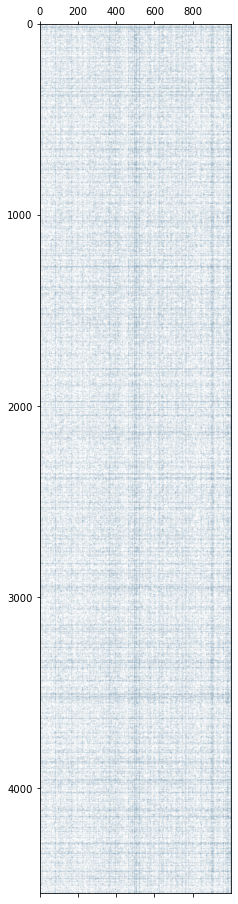

In [18]:
plt.figure(figsize=(20, 16))
plt.spy(X, markersize=0.01)
print(X.nnz, X.shape)

### Специальное SVD для разреженных матриц!

- Как вычислять SVD для плотных матриц было показано на лекции
- Однако у нас матрица разреженная!
- Для таких матриц обычно нужны не все сингулярные числа и вектора, а только первые $k \ll n$
- Для этого используются специальные алгоритмы!
- Пока же просто вызовём функцию из модуля ```scipy.sparse.linalg``` 

In [29]:
u, sigma, v = spsplin.svds(X.asfptype(), k=5)
print(u.shape, v.shape)

(4551, 5) (5, 1000)


### Посмотрим на убывание сингулярных чисел

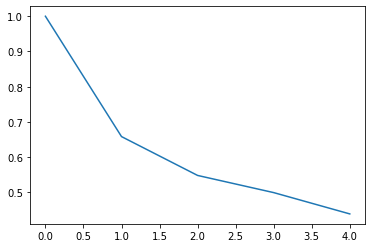

In [30]:
plt.plot(sigma[::-1]/sigma[-1])

In [31]:
terms = vectorizer.get_feature_names()
print(len(terms))
print(terms[:100])

1000
['ability', 'able', 'abortion', 'absolutely', 'abuse', 'accept', 'access', 'according', 'account', 'accounts', 'accused', 'action', 'actor', 'actually', 'added', 'address', 'administration', 'advice', 'afternoon', 'agreed', 'agreement', 'ahead', 'album', 'allow', 'allowed', 'alongside', 'amazon', 'america', 'american', 'americans', 'announced', 'annual', 'answer', 'anti', 'appear', 'appeared', 'appears', 'approach', 'april', 'area', 'areas', 'argument', 'arsenal', 'article', 'artist', 'asked', 'asking', 'asks', 'attack', 'attacks', 'attempt', 'attention', 'audience', 'august', 'australia', 'australian', 'available', 'average', 'avoid', 'away', 'ball', 'band', 'bank', 'banking', 'banks', 'barack', 'barclays', 'based', 'battle', 'beat', 'began', 'beginning', 'believe', 'believes', 'benefit', 'benefits', 'bernie', 'best', 'better', 'biggest', 'black', 'blood', 'blue', 'board', 'body', 'book', 'boris', 'born', 'bournemouth', 'bowie', 'break', 'brexit', 'bring', 'britain', 'british', '

### Темы и "главные" слова для них

In [32]:
for i, comp in enumerate(v):
    print(comp.shape, np.linalg.norm(comp))
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x: x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print("Word: {}, score: {}".format(t[0], t[1]))

(1000,) 1.0000000000000002
Topic 0: 
Word: brexit, score: 0.23235748055210553
Word: britain, score: 0.17638735900062524
Word: referendum, score: 0.15750097605241886
Word: leave, score: 0.15382112490677746
Word: labour, score: 0.14926825473979727
Word: cameron, score: 0.14350282972040673
Word: vote, score: 0.1422022579122943
Word: party, score: 0.11368307674695508
Word: europe, score: 0.10921312901712663
Word: minister, score: 0.10403259053416969
(1000,) 1.000000000000001
Topic 1: 
Word: league, score: 0.32678609720672197
Word: season, score: 0.22923125298198738
Word: leicester, score: 0.19613962597354132
Word: premier, score: 0.18019251209305517
Word: united, score: 0.1739949231324679
Word: goal, score: 0.16976272396141456
Word: liverpool, score: 0.1550333467981107
Word: game, score: 0.15204050404882488
Word: team, score: 0.15152647942627687
Word: players, score: 0.14997394916706688
(1000,) 1.0000000000000009
Topic 2: 
Word: film, score: 0.29264951113026855
Word: album, score: 0.162120

### Темы и "главные" документы для них

In [33]:
top_docs = np.argmax(u, axis=0)
print(top_docs)
for i, j in enumerate(top_docs):
    print("Topic {}".format(i))
    print(documents[j])
    print(" ")

[3179  957 1057 2529 3105]
Topic 0
Cameron names referendum date as Gove declares for Brexit – as it happened • David Cameron has called for his referendum on Britain’s membership of the EU to take place on 23 June, after the cabinet formally agreed to campaign to stay in despite several minister openly supporting Brexit. Speaking from outside Downing Street, the prime minister said he had secured a good deal with Brussels to give the UK a special status and leaving the EU would “threaten our economic and national security”. • Michael Gove has said that the European Union is encouraging extremism across Europe as he joined five other cabinet ministers in breaking ranks with David Cameron to campaign to take Britain out of the EU. The justice secretary, one of the prime minister’s closest political friends, posed for for a photo with his cabinet colleagues at the headquarters of the Vote Leave campaign group shortly after a rare Saturday cabinet meeting. • A marathon round of talks over

### Найдём по данному запросу ближайший документ

In [34]:
new_request_original = '''There were four minutes remaining and none of the Newcastle United fans had left. 
Even with their team a man down and four goals down, they stayed. 
Even with another reminder of how their well-intentioned manager, Steve Bruce, 
struggles to build on the good work of Rafa Benítez, 
they kept standing there, kept singing, defying the rain and the pain.'''

# removing everything except alphabets`
new_request = new_request_original.replace("[^a-zA-Z#]", " ")

# removing short words
new_request = ' '.join([w for w in new_request.split() if len(w)>3])

# make all text lowercase
new_request = new_request.lower()


# tokenization
tokenized_doc = new_request.split()

# remove stop-words
tokenized_doc = [item for item in tokenized_doc if item not in stop_words]

# de-tokenization
detokenized_request = ' '.join(tokenized_doc)

y = vectorizer.transform([detokenized_request]).toarray().T
y.shape, v.shape

((1000, 1), (5, 1000))

In [60]:
score = u @ (sigma[:, np.newaxis] * v.dot(y))
print(score.shape)
idx_best = np.argsort(score.ravel())
print(idx_best.ravel().shape)
print(documents[idx_best.ravel()[-1]])

(4551, 1)
(4551,)
Premier League: 10 things to look out for this weekend 1) Start of a tough run for the Hammers On the last day of the 2006-07 season Manchester United, who had won the title five days earlier, fielded a weakened side – Cristiano Ronaldo, Ryan Giggs, Paul Scholes, Rio Ferdinand and Nemanja Vidic were all left out of the starting XI – at Old Trafford against a West Ham team who needed at least a point to avoid relegation. Carlos Tevez, who was to join United a few weeks later, scored the only goal on the stroke of half-time. “They couldn’t have come to Old Trafford on a better day,” said Sir Alex Ferguson after the game. “We had already won the league and the edge was off our game.” There was also a 1-0 win in December 2001, against a wretchedly out-of-form United side that were completing a memorably horrific run of five defeats in seven league games. Those two games are the Hammers’ only highlights in a miserable run of top-flight visits to Old Trafford that now exten

In [36]:
print(sorted(score.ravel())[::-1][:10])

[0.1914896092903923, 0.18532805403112135, 0.1836073292407635, 0.18193906546074354, 0.1812192858468929, 0.177114229043864, 0.17646270547047274, 0.1763482993766592, 0.17514722020564336, 0.1744858922733313]


## Приложение 2: рекомендательные системы

### Что дано?

- Матрица пользователь-продукт
- Элементы матрицы – рейтинги, если есть
- Неполное заполнение

## Как использовать SVD?

- Оригинальная работа [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Построим вложение пользователей и продуктов в некоторое подпространство $\mathbb{R}^n$
- Для известных предпочтений найдём наиболее близкие продукты в этом подпространстве
- Как это вычислительно сделать?

### Датасет Movielens с рейтингами фильмов

In [61]:
movies = pd.read_csv('movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('ratings.gz', header=0)

### Пример записей

In [62]:
movies.head()

,movienm,genreid
movieid,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,Jumanji (1995),"Adventure, Children's, Fantasy"
3,Grumpier Old Men (1995),"Comedy, Romance"
4,Waiting to Exhale (1995),"Comedy, Drama"
5,Father of the Bride Part II (1995),Comedy


In [64]:
ratings

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [65]:
ratings[['userid', 'movieid']].apply(pd.Series.nunique)

userid     6040
movieid    3706
dtype: int64

### Зададим список предпочтений

In [90]:
best_movies = "Godfather"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

,movienm,genreid
movieid,,
858,"Godfather, The (1972)","Action, Crime, Drama"
1221,"Godfather: Part II, The (1974)","Action, Crime, Drama"
2023,"Godfather: Part III, The (1990)","Action, Crime, Drama"


### Выделим индексы выбранных фильмов

In [91]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([858, 1221, 2023], dtype='int64', name='movieid')


### Создадим матрицу с рейтингами 

In [85]:
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Вычислим SVD

In [86]:
rank = 50
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

### Посмотрим на убывание сингулярных чисел

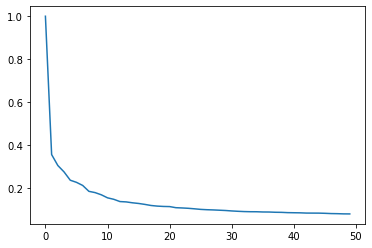

In [87]:
plt.plot(S[::-1] / S[-1])

### Получим корреляции

In [92]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(50, 3)
(3953, 3)
(3953,)


### Вычислим итоговые рекомендации

In [93]:
top_n = 20
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.8412151  0.72298478 0.20254655 0.12884495 0.12727929 0.11651275
 0.10928934 0.10901711 0.09848998 0.09220464 0.08291223 0.07980152
 0.07433467 0.0699485  0.06720786 0.06554852 0.05886816 0.05670393
 0.0564577  0.0531071 ]


,movienm,genreid
movieid,,
858,"Godfather, The (1972)","Action, Crime, Drama"
1221,"Godfather: Part II, The (1974)","Action, Crime, Drama"
2023,"Godfather: Part III, The (1990)","Action, Crime, Drama"
1213,GoodFellas (1990),"Crime, Drama"
1953,"French Connection, The (1971)","Action, Crime, Drama, Thriller"
912,Casablanca (1942),"Drama, Romance, War"
111,Taxi Driver (1976),"Drama, Thriller"
923,Citizen Kane (1941),Drama
2019,Seven Samurai (The Magnificent Seven) (Shichin...,"Action, Drama"


### Обобщения 

- Учёт контекста позволяет внести в скалярное произведение матрицу похожести. Получим гибридную модель SVD, подробности в [этой работе](https://arxiv.org/pdf/1802.06398.pdf)
- Обзор использования нейронных сетей в рекомендательных системах можно найти [тут](https://arxiv.org/pdf/1707.07435.pdf): неочевидные преимущества по сравнению с моделями, основанными на матричных разложениях
-  [Блог про рекомендательные системы](https://www.eigentheories.com/archive.html#)